# Descripción de la Notebook

<b>Antes de levantar los modelos desde los pickles, descomprimir aquellos que están dentro de archivos .rar. Luego de hacer la descompresión, se puede ejecutar la notebook</b>

Lee desde el archivo CSV los datos de los tracks. Aplica algunas transformaciones a los datos y luego entrena diferentes modelos.
Al final se muestran los resultados de todos los modelos, y se realiza una predicción con un set de datos de tracks correspondientes al año 2020.

<a id="titulo"></a>
- <a href="#imports"> Imports </a>
- <a href="#pickle_config"> Seteo de la variable para leer los modelos desde pickle </a>
- <a href="#csv">Se lee el CSV de tracks tranformado. </a>
- <a href="#tratamiento_datos">Transformación de datos</a>
- <a href="#vars_obj">Se definen las clases para la variable objetivo</a>
- <a href="#analisis_datos">Análisis de datos</a>
- <a href="#entrenamiento">Se realiza el entrenamiento para los diferentes modelos</a>
    - <a href="#model_logistic_regression">Logistic Regression</a>
    - <a href="#model_multinomial_naive_bayes">Multinomial Naive Bayes</a>    
    - <a href="#model_knn">KNN</a>   
    - <a href="#model_DTC">Decision Tree Classifier</a>   
    - <a href="#model_random_forest">Random Forest</a>   
    - <a href="#model_extra_tree">Extra tree Classifier</a>
    - <a href="#model_xgboost">XGBoost</a>
- <a href="#feature_selection">Se hace una reducción de features</a>
    - Se vuelve a probar los modelos con features reducidas
        - <a href="#feature_selection_logistic_regression">Logistic Regression</a>
        - <a href="#feature_selection_bernoulli_naive_bayes">Mutinomial Naive Bayes</a>                    
- <a href="#results">Se presentan resultados</a>
- <a href="#metricas">Análisis de métricas</a>
- <a href="#seleccion_modelo">Selección del modelo</a>
- <a href="#test_analysis">Prediciendo en el set de test 2020</a>

# Imports <a id="imports"></a>

<a href="#titulo">Volver al índice</a>

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd
import datetime
import time
import scipy.stats as st

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV #feature selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

from imblearn.over_sampling import SMOTE #pip install -U imbalanced-learn

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_score
from scikitplot.metrics import plot_roc

import pickle

# Importamos bibliotecas propias

In [3]:
import os
import sys
sys.path.append(os.path.abspath("_3_Anexo_Func2.py"))

import _3_Anexo_Func2 as funcs

# Configuracion de la lectura de los modelos desde pickle <a id="pickle_config"></a>

<a href="#titulo">Volver al índice</a>

##### Si esta variable está en False, los modelos se calculan durante la ejecución. SI en cambio está en True, lee los modelos desde los archivos .pkl

In [4]:
leer_modelos_desde_pickle = True

# Levantamos el CSV <a id="csv"></a>

<a href="#titulo">Volver al índice</a>

In [5]:
pathArchivoDataSet = 'tracks_clean.csv' 
df = pd.read_csv(pathArchivoDataSet)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5697 entries, 0 to 5696
Data columns (total 82 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   popularity          5697 non-null   int64  
 1   name                5697 non-null   object 
 2   album               5697 non-null   object 
 3   duration_ms         5697 non-null   int64  
 4   explicit            5697 non-null   int64  
 5   danceability        5697 non-null   float64
 6   energy              5697 non-null   float64
 7   loudness            5697 non-null   float64
 8   mode                5697 non-null   int64  
 9   speechiness         5697 non-null   float64
 10  acousticness        5697 non-null   float64
 11  instrumentalness    5697 non-null   float64
 12  liveness            5697 non-null   float64
 13  valence             5697 non-null   float64
 14  tempo               5697 non-null   float64
 15  artista_generos     5697 non-null   object 
 16  artist

# Tratamiento de variables <a id="tratamiento_datos"></a>

<a href="#titulo">Volver al índice</a>

##### Eliminamos repetidos por nombre de tema y nombre de artista, nos quedamos con el último

In [7]:
df = df.drop_duplicates(subset=['name','artista_name'],keep='last')

##### Quitamos el año para que no genere mucho ruido en el entrenamiento de los modelos

In [8]:
df = df.drop(labels=['release_date'], axis=1)

#### Generación de dummies para el dato 'escala'

In [9]:
df = pd.get_dummies(df, drop_first=True, columns=['escala'])

##### Transformamos la variable duration_ms en duration, que es en minutos

In [10]:
df['duration'] = df['duration_ms'] / 1000 / 60

In [11]:
#quitamos la duracion en ms
df = df.drop(labels=['duration_ms'], axis=1)

# Definimos las clases de la variable objetivo <a id="vars_obj"></a>

<a href="#titulo">Volver al índice</a>

In [12]:
classes_labels = [0,1,2]

In [13]:
def target_classes_generator(popularityValue):
    if(popularityValue < 44):
        return 0
    if(popularityValue >= 44 and popularityValue < 70):
        return 1
    if(popularityValue >= 70):
        return 2

##### Definimos un diccionario para tener labels para el código

In [14]:
target_classes_labels = {0: 'mala', 1: 'buena', 2: 'muy_buena' }

In [15]:
df['popularity_class'] = df['popularity'].apply(lambda p: target_classes_generator(p))

# Análisis de datos <a id="analisis_datos"></a>

<a href="#titulo">Volver al índice</a>

#### Gráfico de la distribución de los valores de popularidad

cambiar el tamaño de los means

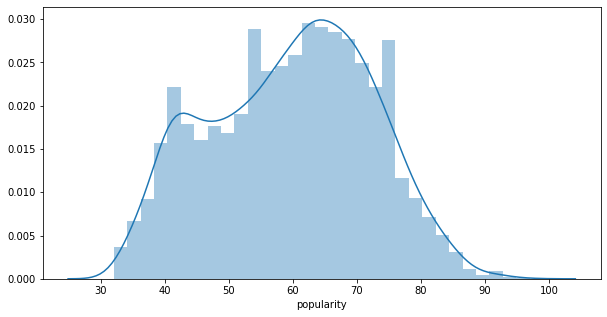

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df['popularity']);

#### Gráfico que muestra las cantidades de tracks para cada una de las clases objetivo definidas

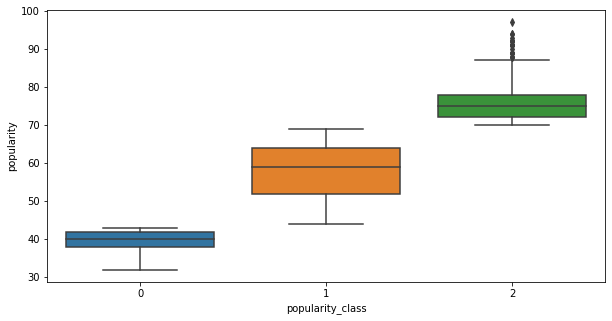

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='popularity_class', y='popularity', data=df)

# Entrenamiento de modelos <a id="entrenamiento"></a>

<a href="#titulo">Volver al índice</a>

In [18]:
#array de diccionarios donde vamos a ir almacenando los resultados para mostrarlos al final
array_resultados = []

def guardar_resultados(label, train_score, test_score):
    array_resultados.append({'modelo': label, 'train_score': train_score, 'test_score':test_score})

In [19]:
training_cols = ['duration', 'explicit',
       'danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'time_signature',
        'genre_cuarteto',
'genre_bachata','genre_k_pop','genre_soul','genre_rock','genre_pop','genre_alternative','genre_hip_hop','genre_ska',
'genre_indie','genre_jazz','genre_metal','genre_trap','genre_reggaeton','genre_reggae','genre_blues','genre_rap',
'genre_disco','genre_folk','genre_punk','genre_r&b','genre_techno','genre_trance','genre_rumba','genre_gothic','genre_cumbia',
'genre_movie','genre_electronic','genre_house','genre_christian','genre_under','genre_groove','genre_funk','genre_anime',
'genre_ambient','genre_country','genre_dance','genre_bolero','genre_bossa_nova','genre_instrumental','genre_classical','genre_melodic',
'genre_hardcore','genre_deep','genre_dubstep','genre_dub','genre_experimental','genre_flamenco','genre_freestyle','genre_mambo',
'genre_merengue','genre_salsa','genre_tango','genre_neo','genre_opera','genre_rave','genre_progressive','genre_samba',
'genre_swing','genre_world','genre_others',
         'escala_Do#', 'escala_Fa', 'escala_Fa#',
       'escala_La', 'escala_La#', 'escala_Mi', 'escala_Re', 'escala_Re#',
       'escala_Si', 'escala_Sol', 'escala_Sol#']

In [20]:
target_col = 'popularity_class'

In [21]:
X = df[training_cols]
y = df[target_col]

##### Vemos que las clases están desbalanceadas

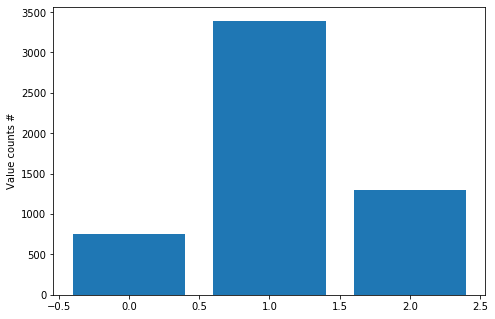

In [22]:
classes_status = pd.Series(y).value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts #')
plt.show()

##### Oversampleamos las clases con menos ocurrencias con smote para balancear los datos

In [23]:
X_simplified_smoted, y_simplified_smoted  = SMOTE().fit_resample(X, y)

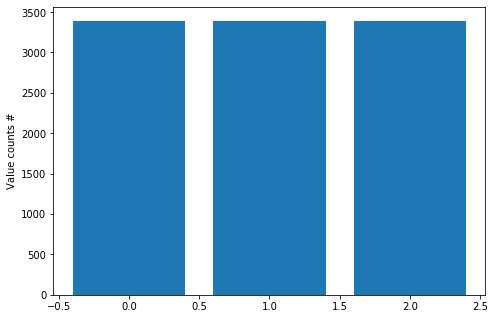

In [24]:
classes_status = pd.Series(y_simplified_smoted).value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts #')
plt.show()

##### Train, test, split para el entrenamiento de modelos

In [25]:
X_train_simplified_smoted, X_test_simplified_smoted, y_train_simplified_smoted, y_test_simplified_smoted = train_test_split(X_simplified_smoted, y_simplified_smoted, test_size=0.3, random_state=42)

## Logistic Regression  <a id="model_logistic_regression"></a>

<a href="#titulo">Volver al índice</a>

In [26]:
reg_log_pasos = [('preprocesamiento', MinMaxScaler()), 
             ('clasificador', linear_model.LogisticRegression())]

reg_log_pipe_grid=Pipeline(reg_log_pasos)

##### Definimos hiperparámetros para el modelo

In [27]:
reg_log_new_param_grid = [{'preprocesamiento':[MinMaxScaler(), StandardScaler()],
                           'clasificador__random_state':[42], 
                           'clasificador__C':np.linspace(115, 130, 10), 
                           'clasificador__penalty':['l2', 'elasticnet'],
                           'clasificador__multi_class':['multinomial'],
                          'clasificador__class_weight':['balanced'],
                          'clasificador__solver': ['newton-cg', 'sag', 'saga','lbfgs']}]

In [28]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
    reg_log_grid=GridSearchCV(reg_log_pipe_grid, reg_log_new_param_grid, cv=kf, n_jobs=-1, verbose=2)
    reg_log_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [29]:
if(not leer_modelos_desde_pickle):
    pickle.dump(reg_log_grid, open('reg_log_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [30]:
reg_log_grid = pickle.load(open('reg_log_grid.pkl', 'rb'))

##### Vemos los resultados

In [31]:
reg_log_grid.best_params_

{'clasificador__C': 123.33333333333333,
 'clasificador__class_weight': 'balanced',
 'clasificador__multi_class': 'multinomial',
 'clasificador__penalty': 'l2',
 'clasificador__random_state': 42,
 'clasificador__solver': 'lbfgs',
 'preprocesamiento': MinMaxScaler()}

##### Resultados sobre el df reducido y smoteado

In [32]:
reg_log_score_training = reg_log_grid.score(X_train_simplified_smoted, y_train_simplified_smoted)
print('Regresión Logística train score: ' + str(reg_log_score_training))

Regresión Logística train score: 0.671855279764409


In [33]:
reg_log_score_test = reg_log_grid.score(X_test_simplified_smoted, y_test_simplified_smoted)
print('Regresión Logística test score: ' + str(reg_log_score_test))

Regresión Logística test score: 0.6588158325155381


In [34]:
guardar_resultados('Logistic Regression', reg_log_score_training, reg_log_score_test)

##### Predictions

In [35]:
reg_log_predicciones = reg_log_grid.predict(X_test_simplified_smoted)

array([680, 166, 134, 108, 765, 169, 178, 288, 569], dtype=int64)

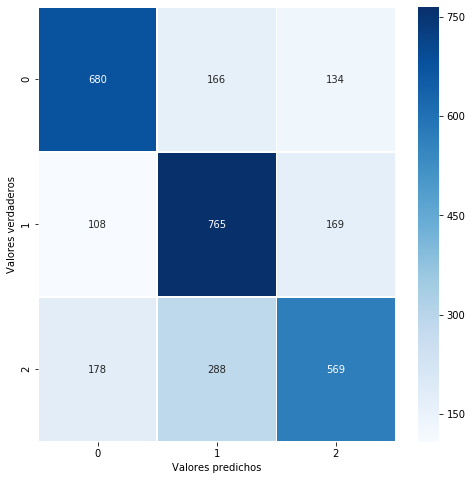

In [36]:
funcs.getConfusionMatrix(y_test_simplified_smoted, reg_log_predicciones, size = 8, labels= classes_labels)

##### Aporte de cada uno de los coeficientes

In [37]:
lr_coeficientes = reg_log_grid.best_estimator_.steps[1][1].coef_

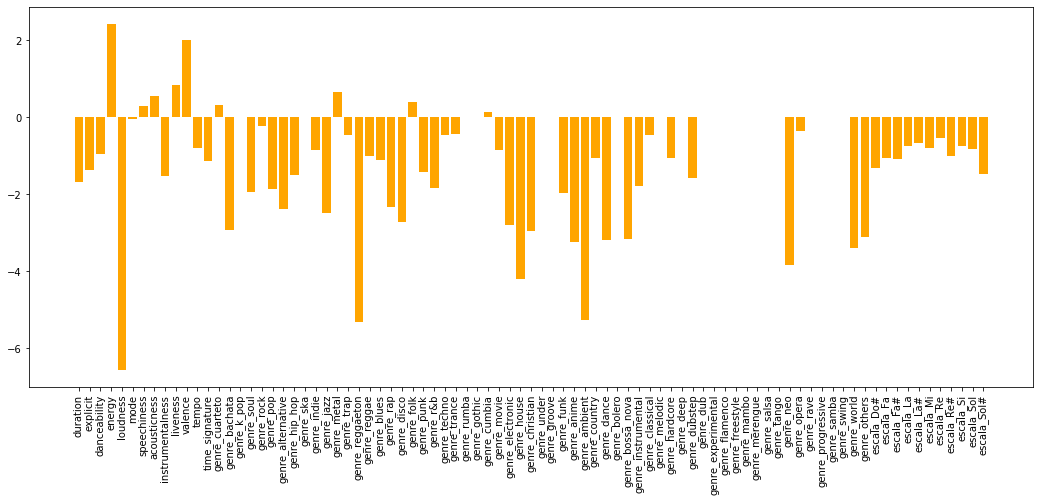

In [38]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(lr_coeficientes[0]))], lr_coeficientes[0],color='orange', linewidth=0.8)
plt.xticks(range(0,len(lr_coeficientes[0])), X_train_simplified_smoted.columns, rotation=90)
plt.show()

## Multinomial Naive Bayes  <a id="model_multinomial_naive_bayes"></a>

<a href="#titulo">Volver al índice</a>

In [39]:
bnb_pasos = [('preprocesamiento', MinMaxScaler()), 
             ('clasificador', MultinomialNB())]

bnb_pipe_grid=Pipeline(bnb_pasos)

##### Definimos hiperparámetros para el modelo

In [40]:
bnb_new_param_grid = [{'preprocesamiento':[MinMaxScaler(), StandardScaler()],
                        'clasificador__alpha':np.linspace(1, 20, 80)}]

In [41]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    mnb_grid=GridSearchCV(bnb_pipe_grid, bnb_new_param_grid, cv=kf, n_jobs=-1, verbose=2)
    mnb_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [42]:
if(not leer_modelos_desde_pickle):
    pickle.dump(mnb_grid, open('mnb_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [43]:
bnb_grid = pickle.load(open('mnb_grid.pkl', 'rb'))

##### Vemos los resultados

In [44]:
bnb_grid.best_params_

{'clasificador__alpha': 3.1645569620253164, 'preprocesamiento': MinMaxScaler()}

In [45]:
bnb_score_training = bnb_grid.score(X_train_simplified_smoted, y_train_simplified_smoted)
print('Multinomial Naive Bayes training score: ' + str(bnb_score_training))

Multinomial Naive Bayes training score: 0.6034216799887814


In [46]:
bnb_score_test = bnb_grid.score(X_test_simplified_smoted, y_test_simplified_smoted)
print('Multinomial Naive Bayes test score: ' + str(bnb_score_test))

Multinomial Naive Bayes test score: 0.5796532548249919


In [47]:
guardar_resultados('Multinomial Naive Bayes', bnb_score_training, bnb_score_test)

##### Predictions

In [48]:
bnb_predicciones = bnb_grid.predict(X_test_simplified_smoted)

array([690,  82, 208, 174, 461, 407, 264, 150, 621], dtype=int64)

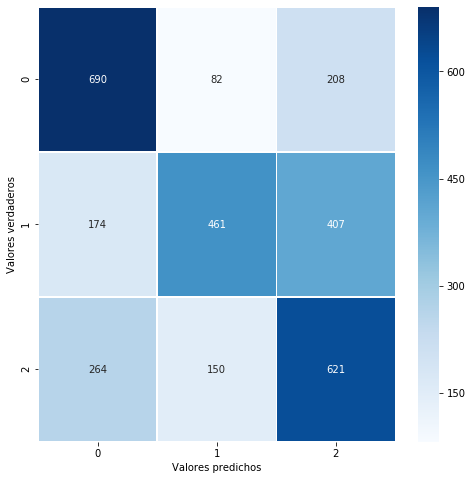

In [49]:
funcs.getConfusionMatrix(y_test_simplified_smoted, bnb_predicciones, size = 8, labels= classes_labels)

## KNN  <a id="model_knn"></a>

<a href="#titulo">Volver al índice</a>

In [50]:
kf = StratifiedKFold(n_splits=3, shuffle = True, random_state=42)
knn_pasos = [('preprocesamiento', MinMaxScaler()), 
             ('clasificador', KNeighborsClassifier(n_neighbors=2))]

knn_pipe_grid=Pipeline(knn_pasos)

##### Definimos los parametros para el gridsearch cv

In [51]:
knn_new_param_grid = [{'preprocesamiento':[MinMaxScaler(), StandardScaler()],
                       'clasificador__n_neighbors':range(1,4,1), 
                       'clasificador__algorithm':['ball_tree', 'kd_tree'],
                       'clasificador__leaf_size':[2,5,8],#este hiperparametro solo funciona cuando se usa ball_tree o kd_tree
                       'clasificador__weights':['uniform','distance']}                     
                        ,
                     {'preprocesamiento':[MinMaxScaler(), StandardScaler()],
                       'clasificador__n_neighbors':range(1,4,1), 
                       'clasificador__algorithm':['brute'],
                       'clasificador__weights':['uniform','distance']}]

In [52]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    knn_grid=GridSearchCV(knn_pipe_grid, knn_new_param_grid, cv=kf, n_jobs=-1,verbose=2)
    knn_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [53]:
if(not leer_modelos_desde_pickle):
    pickle.dump(knn_grid, open('knn_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [54]:
knn_grid = pickle.load(open('knn_grid.pkl', 'rb'))

##### Vemos los mejores parametros resultantes

In [55]:
knn_grid.best_params_

{'clasificador__algorithm': 'ball_tree',
 'clasificador__leaf_size': 2,
 'clasificador__n_neighbors': 3,
 'clasificador__weights': 'distance',
 'preprocesamiento': StandardScaler()}

In [56]:
knn_score_training = knn_grid.score(X_train_simplified_smoted, y_train_simplified_smoted)
print('KNN training score: ' + str(knn_score_training))

KNN training score: 0.9408217641284532


In [57]:
knn_score_test = knn_grid.score(X_test_simplified_smoted, y_test_simplified_smoted)
print('KNN test score: ' + str(knn_score_test))

KNN test score: 0.7078835459600916


In [58]:
guardar_resultados('KNN', knn_score_training, knn_score_test)

##### Predictions

In [59]:
knn_y_pred = knn_grid.predict(X_test_simplified_smoted)

##### Analizamos los resultados en la matriz de confusión

array([782, 111,  87, 140, 647, 255, 115, 185, 735], dtype=int64)

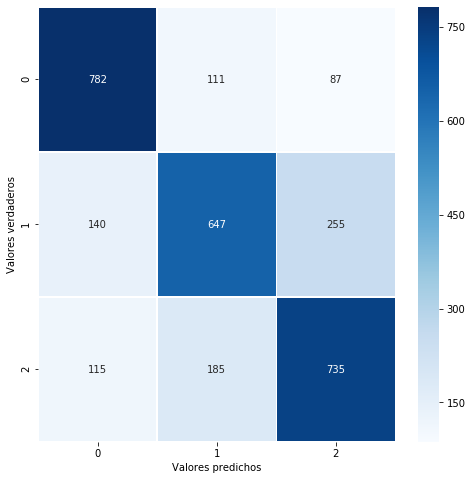

In [60]:
funcs.getConfusionMatrix(y_test_simplified_smoted, knn_y_pred, size= 8, labels= classes_labels)

## Decision Tree Classifier  <a id="model_DTC"></a>

<a href="#titulo">Volver al índice</a>

In [61]:
tree_overfit = DecisionTreeClassifier(random_state=42)
tree_overfit.fit(X_train_simplified_smoted, y_train_simplified_smoted)

DecisionTreeClassifier(random_state=42)

In [62]:
print('Sin restringir el árbol podemos ver que overfitea:')
print('Classifier tree training score: ' + str(tree_overfit.score(X_train_simplified_smoted, y_train_simplified_smoted)))
print('Classifier tree test score: ' + str(tree_overfit.score(X_test_simplified_smoted, y_test_simplified_smoted)))

Sin restringir el árbol podemos ver que overfitea:
Classifier tree training score: 0.9998597672135745
Classifier tree test score: 0.6319921491658489


##### Creamos el pipe

In [63]:
dtc_log_pasos = [('preprocesamiento', StandardScaler()), 
             ('clasificador', DecisionTreeClassifier(random_state=42))]

dtc_pipe_grid=Pipeline(dtc_log_pasos)

##### Definimos hiperparámetros para el modelo

In [64]:
dtc_new_param_grid = [{'clasificador__max_depth':[7,8,9], 
                       'clasificador__max_features':[5,10,15],                     
                      }]

In [65]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=12)
    dtc_log_grid=GridSearchCV(dtc_pipe_grid, dtc_new_param_grid, cv=kf, n_jobs=-1, verbose=2)
    dtc_log_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [66]:
if(not leer_modelos_desde_pickle):
    pickle.dump(dtc_log_grid, open('dtc_log_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [67]:
dtc_log_grid = pickle.load(open('dtc_log_grid.pkl', 'rb'))

In [68]:
print('Mejor estimador GridCV: ' + str(dtc_log_grid.best_estimator_))
print('Mejor score GridCV: ' + str(dtc_log_grid.best_score_))

Mejor estimador GridCV: Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('clasificador',
                 DecisionTreeClassifier(max_depth=8, max_features=10,
                                        random_state=42))])
Mejor score GridCV: 0.5431215818258309


In [69]:
dtc_log_grid.best_params_

{'clasificador__max_depth': 8, 'clasificador__max_features': 10}

In [70]:
classifier_tree_score_training = dtc_log_grid.best_estimator_.score(X_train_simplified_smoted,y_train_simplified_smoted)
print('Classifier tree training score: ' + str(classifier_tree_score_training))

Classifier tree training score: 0.5725704669751788


In [71]:
classifier_tree_score_test = dtc_log_grid.best_estimator_.score(X_test_simplified_smoted, y_test_simplified_smoted)
print('Classifier tree training score: ' + str(classifier_tree_score_test))

Classifier tree training score: 0.5227347072293098


In [72]:
guardar_resultados('Decision Tree Classifier', classifier_tree_score_training, classifier_tree_score_test)

In [73]:
# Calcular la importancia de los atributos
tree_importancia_atributos = pd.DataFrame({'Atributo':X_train_simplified_smoted.columns,'importancia':dtc_log_grid.best_estimator_['clasificador'].feature_importances_}).sort_values('importancia', ascending=False)

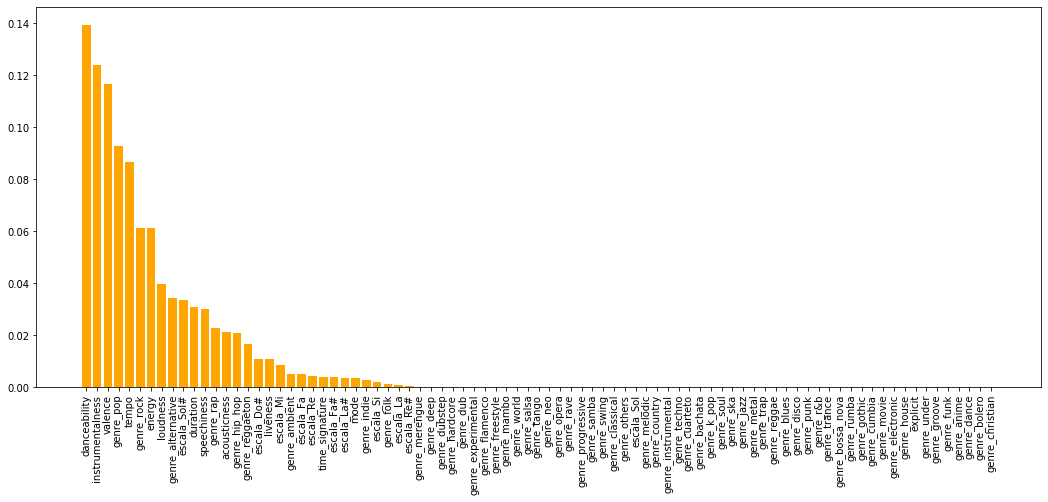

In [74]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(tree_importancia_atributos['importancia']))], tree_importancia_atributos['importancia'],color='orange', linewidth=0.8)
plt.xticks(range(0,len(tree_importancia_atributos['Atributo'])), tree_importancia_atributos['Atributo'], rotation=90)
plt.show()

##### Predictions

In [75]:
classifier_tree_y_pred = dtc_log_grid.best_estimator_.predict(X_test_simplified_smoted)

##### Analizamos los resultados en la matriz de confusión

array([595,  77, 308, 238, 378, 426, 214, 196, 625], dtype=int64)

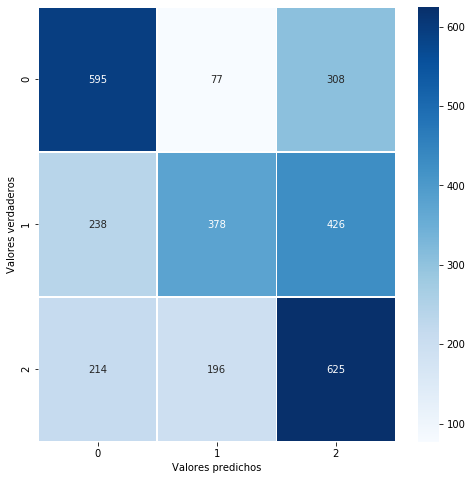

In [76]:
funcs.getConfusionMatrix(y_test_simplified_smoted, classifier_tree_y_pred, size= 8, labels= classes_labels)

## Random Forest <a id="model_random_forest"></a>

<a href="#titulo">Volver al índice</a>

##### Creamos el pipe

In [77]:
random_forest_pasos = [('preprocesamiento', StandardScaler()), 
                 ('clasificador', RandomForestClassifier(class_weight='balanced', random_state=42))]

random_forest_pipe_grid=Pipeline(random_forest_pasos)

##### Definimos hiperparámetros para el modelo

In [78]:
random_forest_param_grid = [{
                       'clasificador__n_estimators':[1000],                       
                       'clasificador__max_depth':[10, 15], 
                       'clasificador__max_features':[3, 5, 7]
                      }]


In [79]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=12)
    random_forest_grid=GridSearchCV(random_forest_pipe_grid, random_forest_param_grid, cv=kf, n_jobs=-1, verbose=2)
    random_forest_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [80]:
if(not leer_modelos_desde_pickle):
    pickle.dump(random_forest_grid, open('random_forest_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [81]:
random_forest_grid = pickle.load(open('random_forest_grid.pkl', 'rb'))

In [82]:
print('Mejor estimador GridCV: ' + str(random_forest_grid.best_estimator_))
print('Mejor score GridCV: ' + str(random_forest_grid.best_score_))

Mejor estimador GridCV: Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('clasificador',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        max_features=7, n_estimators=1000,
                                        random_state=42))])
Mejor score GridCV: 0.7216379189454495


In [83]:
random_forest_score_training = random_forest_grid.best_estimator_.score(X_train_simplified_smoted,y_train_simplified_smoted)
print('Random forest training score: ' + str(random_forest_score_training))

Random forest training score: 0.9113728789791053


In [84]:
random_forest_score_test = random_forest_grid.best_estimator_.score(X_test_simplified_smoted, y_test_simplified_smoted)
print('Random forest tree training score: ' + str(random_forest_score_test))

Random forest tree training score: 0.7314360484134773


In [85]:
guardar_resultados('Random Forest', random_forest_score_training, random_forest_score_test)

##### Predictions

In [86]:
random_forest_y_pred = random_forest_grid.best_estimator_.predict(X_test_simplified_smoted)

##### Analizamos los resultados en la matriz de confusión

array([847,  67,  66, 182, 646, 214, 149, 143, 743], dtype=int64)

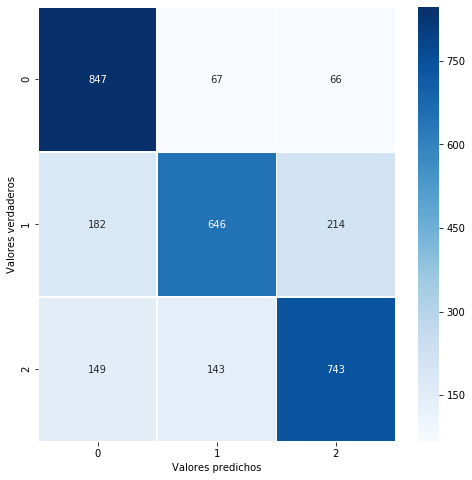

In [87]:
funcs.getConfusionMatrix(y_test_simplified_smoted, random_forest_y_pred, size= 8, labels= classes_labels)

In [88]:
# Calcular la importancia de los atributos
rf_importancia_atributos = pd.DataFrame({'Atributo':X_train_simplified_smoted.columns,'importancia':random_forest_grid.best_estimator_['clasificador'].feature_importances_}).sort_values('importancia', ascending=False)

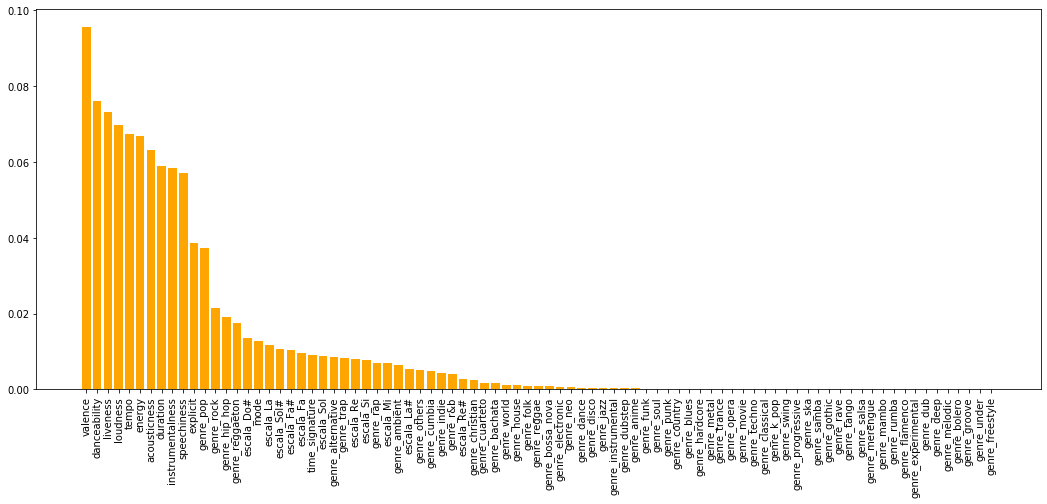

In [89]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(rf_importancia_atributos['importancia']))], rf_importancia_atributos['importancia'],color='orange', linewidth=0.8)
plt.xticks(range(0,len(rf_importancia_atributos['Atributo'])), rf_importancia_atributos['Atributo'], rotation=90)
plt.show()

## Extra Tree Classifier<a id="model_extra_tree"></a>

<a href="#titulo">Volver al índice</a>

##### Creamos el pipe

In [90]:
extra_tree_pasos = [('preprocesamiento', StandardScaler()), 
                 ('clasificador', ExtraTreesClassifier(class_weight='balanced', random_state=42))]

random_forest_pipe_grid=Pipeline(random_forest_pasos)

##### Definimos hiperparámetros para el modelo

In [91]:
extra_tree_param_grid = [{
                       'clasificador__n_estimators':[1000],
                       'clasificador__max_depth':[10, 12],
                        'clasificador__max_features':[10, 15, 20]
                      }]


In [92]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=12)
    extra_tree_grid=GridSearchCV(random_forest_pipe_grid, extra_tree_param_grid, cv=kf, n_jobs=-1, verbose=2)
    extra_tree_grid.fit(X_train_simplified_smoted, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [93]:
if(not leer_modelos_desde_pickle):
    pickle.dump(extra_tree_grid, open('extra_tree_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [94]:
extra_tree_grid = pickle.load(open('extra_tree_grid.pkl', 'rb'))

In [95]:
print('Mejor estimador GridCV: ' + str(extra_tree_grid.best_estimator_))
print('Mejor score GridCV: ' + str(extra_tree_grid.best_score_))

Mejor estimador GridCV: Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('clasificador',
                 RandomForestClassifier(class_weight='balanced', max_depth=12,
                                        max_features=10, n_estimators=1000,
                                        random_state=42))])
Mejor score GridCV: 0.7011639321273314


In [96]:
extra_tree_score_training = extra_tree_grid.best_estimator_.score(X_train_simplified_smoted,y_train_simplified_smoted)
print('Extra tree training score: ' + str(extra_tree_score_training))

Extra tree training score: 0.8557004627681952


In [97]:
extra_tree_score_test = extra_tree_grid.best_estimator_.score(X_test_simplified_smoted, y_test_simplified_smoted)
print('Extra tree training score: ' + str(extra_tree_score_test))

Extra tree training score: 0.693490350016356


In [98]:
guardar_resultados('Extra Trees Classifier', extra_tree_score_training, extra_tree_score_test)

##### Predictions

In [99]:
extra_tree_y_pred = extra_tree_grid.best_estimator_.predict(X_test_simplified_smoted)

##### Analizamos los resultados en la matriz de confusión

array([832,  63,  85, 221, 584, 237, 181, 150, 704], dtype=int64)

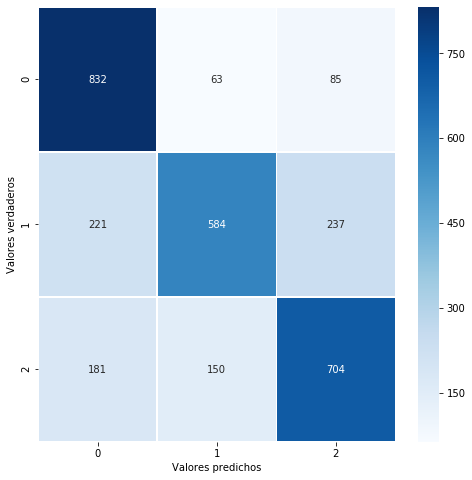

In [100]:
funcs.getConfusionMatrix(y_test_simplified_smoted, extra_tree_y_pred, size= 8, labels= classes_labels)

In [101]:
# Calcular la importancia de los atributos
et_importancia_atributos = pd.DataFrame({'Atributo':X_train_simplified_smoted.columns,'importancia':extra_tree_grid.best_estimator_['clasificador'].feature_importances_}).sort_values('importancia', ascending=False)

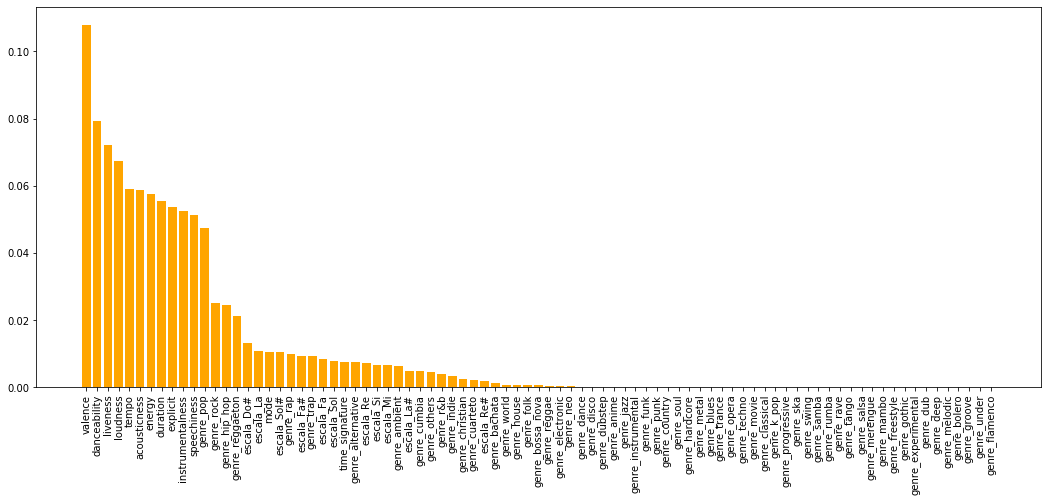

In [102]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(et_importancia_atributos['importancia']))], et_importancia_atributos['importancia'],color='orange', linewidth=0.8)
plt.xticks(range(0,len(et_importancia_atributos['Atributo'])), et_importancia_atributos['Atributo'], rotation=90)
plt.show()

## XGBoost <a id="model_xgboost"></a>

<a href="#titulo">Volver al índice</a>

In [103]:
scaler = StandardScaler()
X_train_simplified_smoted_scaled = scaler.fit_transform(X_train_simplified_smoted)
X_test_simplified_smoted_scaled = scaler.transform(X_test_simplified_smoted)

##### Instanciamos el modelo

In [104]:
model_xg = XGBClassifier(n_jobs=-1, random_state=42)

In [105]:
params = {  
    "n_estimators": st.randint(10,100), # Number of boosted trees to fit.
     "max_depth": st.randint(5, 80),     # Maximum tree depth for base learners. 
}

In [106]:
xgb = RandomizedSearchCV(model_xg,params, n_iter=100, verbose= True)

In [107]:
if(not leer_modelos_desde_pickle):
    start = time.time()
    xgb.fit(X_train_simplified_smoted_scaled, y_train_simplified_smoted)
    end = time.time()
    print("--- %s seconds ---" % (end - start))

##### Lo guardamos en pickle

In [108]:
if(not leer_modelos_desde_pickle):
    pickle.dump(xgb, open('xgb_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [109]:
xgb = pickle.load(open('xgb_grid.pkl', 'rb'))

In [110]:
print('Mejores parametros: ' + str(xgb.best_params_))
print('Mejor score: ' + str(xgb.best_score_))

Mejores parametros: {'max_depth': 19, 'n_estimators': 70}
Mejor score: 0.7771695147972728


In [111]:
xgboost_score_training = xgb.score(X_train_simplified_smoted_scaled, y_train_simplified_smoted)
print('XGBoost training score: ' + str(xgboost_score_training))

XGBoost training score: 0.9507782919646613


In [112]:
xgboost_score_test = xgb.score(X_test_simplified_smoted_scaled, y_test_simplified_smoted)
print('XGBoost test score: ' + str(xgboost_score_test))

XGBoost test score: 0.7814851161269218


In [113]:
guardar_resultados('XGBoost', xgboost_score_training, xgboost_score_test)

##### Predictions

In [114]:
xgb_y_pred = xgb.best_estimator_.predict(X_test_simplified_smoted_scaled)

##### Analizamos los resultados en la matriz de confusión

array([820, 116,  44, 101, 787, 154,  62, 191, 782], dtype=int64)

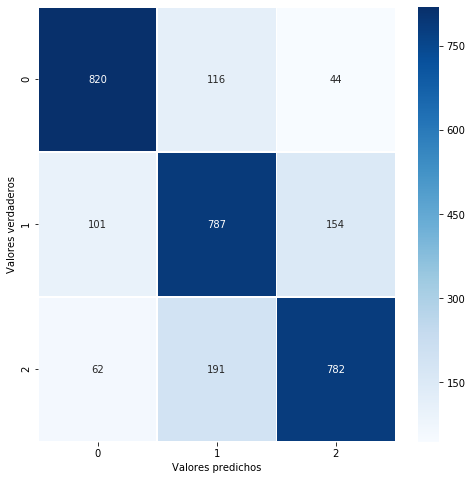

In [115]:
funcs.getConfusionMatrix(y_test_simplified_smoted, xgb_y_pred, size= 8, labels= classes_labels)

##### Best features

In [116]:
# Calcular la importancia de los atributos
xgb_importancia_atributos = pd.DataFrame({'Atributo':X_train_simplified_smoted.columns,'importancia':xgb.best_estimator_.feature_importances_}).sort_values('importancia', ascending=False)

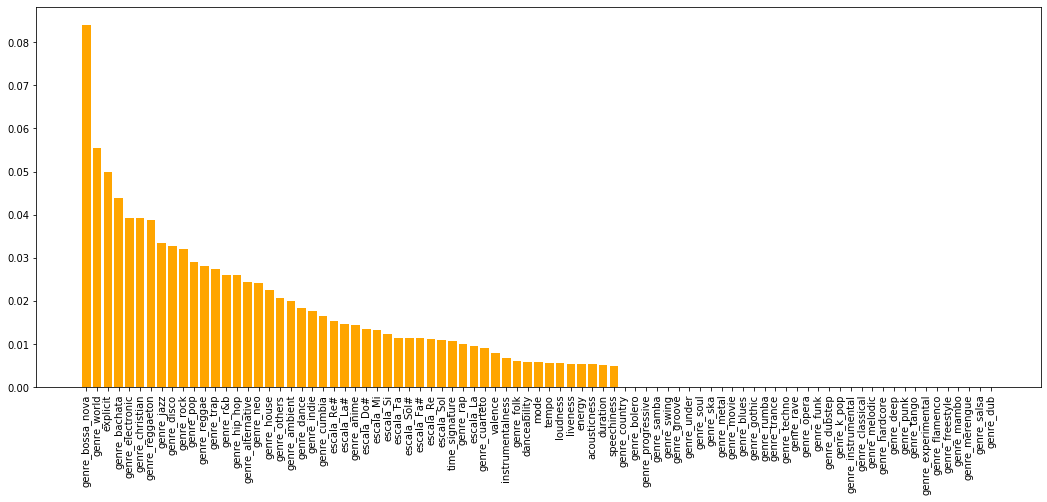

In [117]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(xgb_importancia_atributos['importancia']))], xgb_importancia_atributos['importancia'],color='orange', linewidth=0.8)
plt.xticks(range(0,len(xgb_importancia_atributos['Atributo'])), xgb_importancia_atributos['Atributo'], rotation=90)
plt.show()

# Feature Selection <a id="feature_selection"></a>

## Logistic Regression <a id="feature_selection_logistic_regression"></a>

<a href="#titulo">Volver al índice</a>

##### Definimos el feature selector

In [118]:
kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
estimator = linear_model.LogisticRegression()
selector = RFECV(estimator, step = 1, cv=kf, scoring = 'neg_mean_squared_error', verbose=2)

##### Definimos un grid search, para optimizar el feature selector con el hiperparámetro C de la regresión logística obtenido para todo el DF

In [119]:
X_train_simplified_smoted_scaled = reg_log_grid.best_params_['preprocesamiento'].fit_transform(X_train_simplified_smoted)
X_test_simplified_smoted_scaled = reg_log_grid.best_params_['preprocesamiento'].transform(X_test_simplified_smoted)

grid_hiperparametros = {'estimator__random_state': [reg_log_grid.best_params_['clasificador__random_state']], 
                        'estimator__C':[reg_log_grid.best_params_['clasificador__C']], 
                        'estimator__penalty':[reg_log_grid.best_params_['clasificador__penalty']],
                        'estimator__multi_class':[reg_log_grid.best_params_['clasificador__multi_class']],
                        'estimator__class_weight':[reg_log_grid.best_params_['clasificador__class_weight']],
                        'estimator__solver': [reg_log_grid.best_params_['clasificador__solver']]                       
                       }

In [120]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    reg_log_fs_grid = RandomizedSearchCV(estimator=selector, param_distributions=grid_hiperparametros, cv=kf, random_state = 42,n_jobs=-1,verbose=2)
    reg_log_fs_grid.fit(X_train_simplified_smoted_scaled, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [121]:
if(not leer_modelos_desde_pickle):
    pickle.dump(reg_log_fs_grid, open('reg_log_fs_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [122]:
reg_log_fs_grid = pickle.load(open('reg_log_fs_grid.pkl', 'rb'))

### Analizamos cómo resultó el feature selection

In [123]:
print("Número original de features : %d" % len(training_cols))
print("Número óptimo de features : %d" % reg_log_fs_grid.best_estimator_.n_features_)

Número original de features : 85
Número óptimo de features : 65


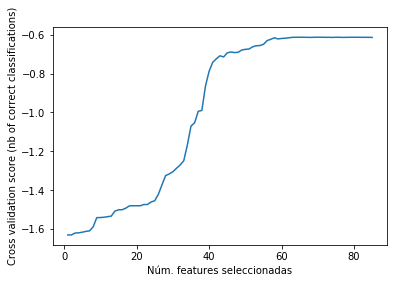

In [124]:
#Grafico que muestra el score del cross validation, dependiendo de la cantidad de features seleccionadas
plt.figure()
plt.xlabel("Núm. features seleccionadas")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(reg_log_fs_grid.best_estimator_.grid_scores_) + 1), reg_log_fs_grid.best_estimator_.grid_scores_)
plt.show()

In [125]:
reg_log_FS_score_training = reg_log_fs_grid.best_score_
print('Regresión Logística FS train score: ' + str(reg_log_FS_score_training))

Regresión Logística FS train score: 0.6652646663082546


In [126]:
X_test_FS = reg_log_grid.best_params_['preprocesamiento'].fit_transform(X_test_simplified_smoted)
reg_log_FS_score_test = reg_log_fs_grid.score(X_test_FS, y_test_simplified_smoted)
print('Regresión Logística FS trainig score: ' + str(reg_log_FS_score_test))

Regresión Logística FS trainig score: 0.6535819430814525


In [127]:
guardar_resultados('Logistic Regresion Feature Selection', reg_log_FS_score_training, reg_log_FS_score_test)

##### Predictions

In [128]:
FS_reg_log_predicciones = reg_log_fs_grid.predict(X_test_FS)

array([732, 150,  98, 142, 729, 171, 216, 282, 537], dtype=int64)

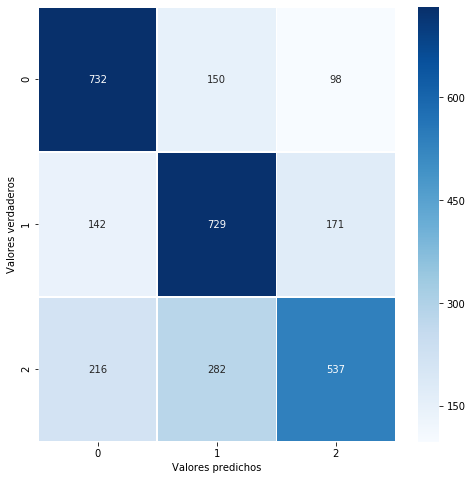

In [129]:
funcs.getConfusionMatrix(y_test_simplified_smoted, FS_reg_log_predicciones, size = 8, labels= classes_labels)

##### Aporte de cada uno de los coeficientes

In [130]:
lr_coeficientes = reg_log_fs_grid.best_estimator_.estimator_.coef_

##### Clase 2 (tema muy bueno)

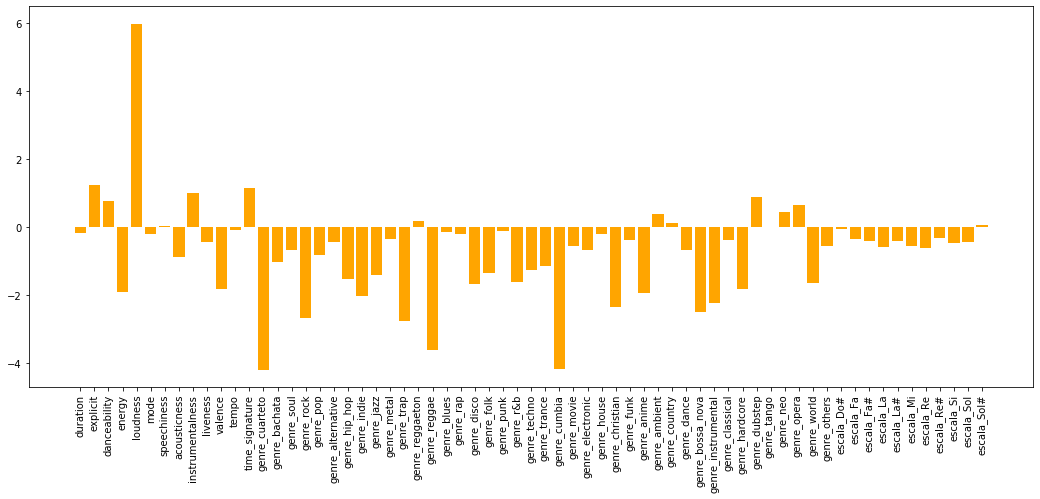

In [131]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(lr_coeficientes[2]))], lr_coeficientes[2],color='orange', linewidth=0.8)
plt.xticks(range(0,len(lr_coeficientes[2])), X_train_simplified_smoted[X_train_simplified_smoted.columns[reg_log_fs_grid.best_estimator_.support_]].columns, rotation=90)
plt.show()

##### Clase 1 (bueno)

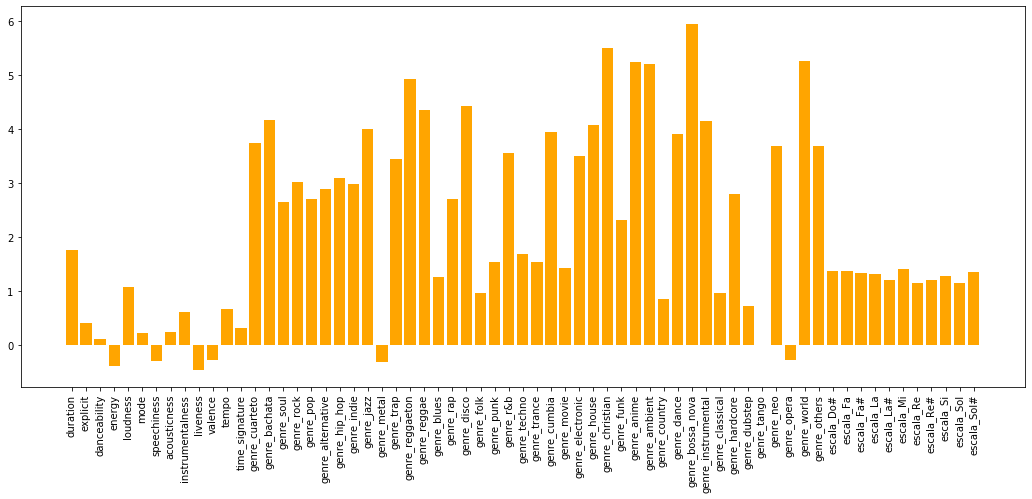

In [132]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(lr_coeficientes[1]))], lr_coeficientes[1],color='orange', linewidth=0.8)
plt.xticks(range(0,len(lr_coeficientes[1])), X_train_simplified_smoted[X_train_simplified_smoted.columns[reg_log_fs_grid.best_estimator_.support_]].columns, rotation=90)
plt.show()

##### Clase 0 (malo)

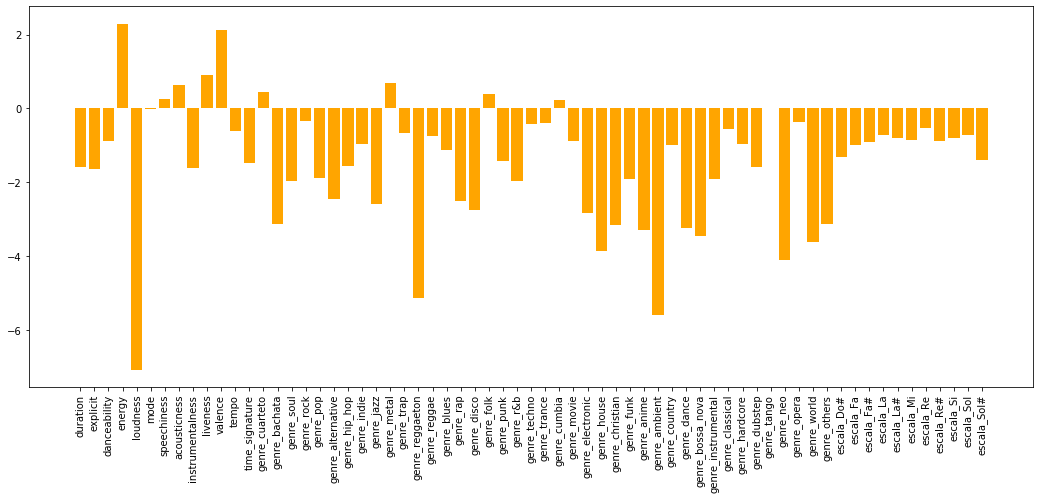

In [133]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(lr_coeficientes[0]))], lr_coeficientes[0],color='orange', linewidth=0.8)
plt.xticks(range(0,len(lr_coeficientes[0])), X_train_simplified_smoted[X_train_simplified_smoted.columns[reg_log_fs_grid.best_estimator_.support_]].columns, rotation=90)
plt.show()

## Multinomial Naive Bayes  <a id="feature_selection_bernoulli_naive_bayes"></a>

<a href="#titulo">Volver al índice</a>

##### Definimos el feature selector

In [134]:
kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
estimator = MultinomialNB()
selector = RFECV(estimator, step = 1, cv=kf, scoring = 'neg_mean_squared_error', verbose=2)

##### Definimos un grid search, para optimizar el feature selector con el hiperparámetro C de la regresión logística obtenido para todo el DF

In [135]:
X_train_simplified_smoted_scaled = bnb_grid.best_params_['preprocesamiento'].fit_transform(X_train_simplified_smoted)
X_test_simplified_smoted_scaled = bnb_grid.best_params_['preprocesamiento'].transform(X_test_simplified_smoted)

grid_hiperparametros = {'estimator__alpha': [bnb_grid.best_params_['clasificador__alpha']],                                             
                       }

In [136]:
if(not leer_modelos_desde_pickle):
    start_time = time.time()
    mnb_fs_grid = RandomizedSearchCV(estimator=selector, param_distributions=grid_hiperparametros, cv=kf, random_state = 42,n_jobs=-1,verbose=2)
    mnb_fs_grid.fit(X_train_simplified_smoted_scaled, y_train_simplified_smoted)
    print("--- %s seconds ---" % (time.time() - start_time))

##### Lo guardamos en pickle

In [137]:
if(not leer_modelos_desde_pickle):
    pickle.dump(mnb_fs_grid, open('mnb_fs_grid.pkl', 'wb'))

##### Si ejecutamos levantando el pickle, lo hacemos

In [138]:
mnb_fs_grid = pickle.load(open('mnb_fs_grid.pkl', 'rb'))

### Analizamos cómo resultó el feature selection

In [139]:
print("Número original de features : %d" % len(training_cols))
print("Número óptimo de features : %d" % mnb_fs_grid.best_estimator_.n_features_)

Número original de features : 85
Número óptimo de features : 84


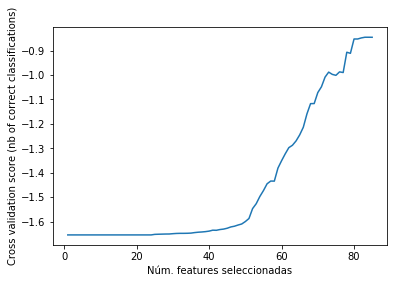

In [140]:
#Grafico que muestra el score del cross validation, dependiendo de la cantidad de features seleccionadas
plt.figure()
plt.xlabel("Núm. features seleccionadas")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(mnb_fs_grid.best_estimator_.grid_scores_) + 1), mnb_fs_grid.best_estimator_.grid_scores_)
plt.show()

##### Vemos los resultados

In [141]:
bnb_FS_score_training = mnb_fs_grid.best_score_
print('Multinomial Naive Bayes FS training score: ' + str(bnb_FS_score_training))

Multinomial Naive Bayes FS training score: 0.5962690095149545


In [142]:
X_test_FS = bnb_grid.best_params_['preprocesamiento'].fit_transform(X_test_simplified_smoted)
bnb_FS_score_test = mnb_fs_grid.score(X_test_FS, y_test_simplified_smoted)
print('Multinomial Naive Bayes FS test score: ' + str(bnb_FS_score_test))

Multinomial Naive Bayes FS test score: 0.5783447824664704


In [143]:
guardar_resultados('Multinomial Naive Bayes Feature Selection', bnb_FS_score_training, bnb_FS_score_test)

##### Predictions

In [144]:
FS_bnb_predicciones = mnb_fs_grid.predict(X_test_FS)

array([706,  89, 185, 196, 469, 377, 281, 161, 593], dtype=int64)

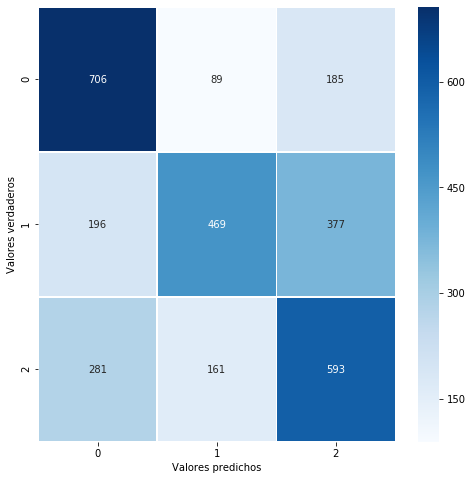

In [145]:
funcs.getConfusionMatrix(y_test_simplified_smoted, FS_bnb_predicciones, size = 8, labels= classes_labels)

# Resultados <a id="results"></a>

<a href="#titulo">Volver al índice</a>

In [146]:
#Resultados de todos los modelos, ordenados por el score de testing descendente
df_resultados = pd.DataFrame(array_resultados)
df_resultados.sort_values('test_score', ascending=False)

,modelo,train_score,test_score
6,XGBoost,0.950778,0.781485
4,Random Forest,0.911373,0.731436
2,KNN,0.940822,0.707884
5,Extra Trees Classifier,0.855700,0.693490
0,Logistic Regression,0.671855,0.658816
7,Logistic Regresion Feature Selection,0.665265,0.653582
1,Multinomial Naive Bayes,0.603422,0.579653
8,Multinomial Naive Bayes Feature Selection,0.596269,0.578345
3,Decision Tree Classifier,0.572570,0.522735


In [147]:
print('SIN FEATURE SELECTION: ')
print('-----------------------------------------------------------')
print('Regresion Logistica')
print(classification_report(y_test_simplified_smoted,reg_log_predicciones))
print('-----------------------------------------------------------')
print('Multinomial Naive Bayes')
print(classification_report(y_test_simplified_smoted,bnb_predicciones))
print('-----------------------------------------------------------')
print('KNN')
print(classification_report(y_test_simplified_smoted,knn_y_pred))
print('-----------------------------------------------------------')
print('Decision Tree Classifier')
print(classification_report(y_test_simplified_smoted,classifier_tree_y_pred))
print('-----------------------------------------------------------')
print('Random Forest')
print(classification_report(y_test_simplified_smoted,random_forest_y_pred))
print('-----------------------------------------------------------')
print('Extra Trees')
print(classification_report(y_test_simplified_smoted,extra_tree_y_pred))
print('-----------------------------------------------------------')
print('XGBoost')
print(classification_report(y_test_simplified_smoted,xgb_y_pred))

SIN FEATURE SELECTION: 
-----------------------------------------------------------
Regresion Logistica
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       980
           1       0.63      0.73      0.68      1042
           2       0.65      0.55      0.60      1035

    accuracy                           0.66      3057
   macro avg       0.66      0.66      0.66      3057
weighted avg       0.66      0.66      0.66      3057

-----------------------------------------------------------
Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.61      0.70      0.65       980
           1       0.67      0.44      0.53      1042
           2       0.50      0.60      0.55      1035

    accuracy                           0.58      3057
   macro avg       0.59      0.58      0.58      3057
weighted avg       0.59      0.58      0.58      3057

--------------------------------------------------

In [148]:
print('CON FEATURE SELECTION: ')
print('-----------------------------------------------------------')
print('Regresion Logistica')
print(classification_report(y_test_simplified_smoted,FS_reg_log_predicciones))
print('-----------------------------------------------------------')
print('Multinomial Naive Bayes')
print(classification_report(y_test_simplified_smoted,FS_bnb_predicciones))
print('-----------------------------------------------------------')

CON FEATURE SELECTION: 
-----------------------------------------------------------
Regresion Logistica
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       980
           1       0.63      0.70      0.66      1042
           2       0.67      0.52      0.58      1035

    accuracy                           0.65      3057
   macro avg       0.66      0.66      0.65      3057
weighted avg       0.65      0.65      0.65      3057

-----------------------------------------------------------
Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.60      0.72      0.65       980
           1       0.65      0.45      0.53      1042
           2       0.51      0.57      0.54      1035

    accuracy                           0.58      3057
   macro avg       0.59      0.58      0.58      3057
weighted avg       0.59      0.58      0.57      3057

--------------------------------------------------

# Análisis de Métricas <a id="metricas"></a>

<a href="#titulo">Volver al índice</a>

Dado que lo importante para nuestro modelo es que lo clasificado como un tema Muy Bueno (clase 2) sea realmente cierto (no un falso positivo), analizamos los resultados para las métricas Precision y Recall para la clase que nos interesa (la clase 2).

##### Precision

In [149]:
precision_metrics = []

#regresion logistica
precision_metrics.append({"precision_score": classification_report(y_test_simplified_smoted,reg_log_predicciones, output_dict=True)['2']['precision'], "model": "Reg Logisitica"})
#Multinomial NB
precision_metrics.append({"precision_score": classification_report(y_test_simplified_smoted,bnb_predicciones, output_dict=True)['2']['precision'], "model": "Multinomial NB"})
#KNN
precision_metrics.append({"precision_score": classification_report(y_test_simplified_smoted,knn_y_pred, output_dict=True)['2']['precision'], "model": "KNN (K="+ str(knn_grid.best_params_['clasificador__n_neighbors']) +")"})
#Decision Tree Classifier
precision_metrics.append({"precision_score": classification_report(y_test_simplified_smoted,classifier_tree_y_pred, output_dict=True)['2']['precision'], "model": "Decision Tree Classifier"})
#Random Forest
precision_metrics.append({"precision_score": classification_report(y_test_simplified_smoted,random_forest_y_pred, output_dict=True)['2']['precision'], "model": "Random Forest"})
#Extra Trees
precision_metrics.append({"precision_score": classification_report(y_test_simplified_smoted,extra_tree_y_pred, output_dict=True)['2']['precision'], "model": "Extra Tree"})
#XGBoost
precision_metrics.append({"precision_score": classification_report(y_test_simplified_smoted,xgb_y_pred, output_dict=True)['2']['precision'], "model": "XGBoost"})
#Regresion Logistica con FS
precision_metrics.append({"precision_score": classification_report(y_test_simplified_smoted,FS_reg_log_predicciones, output_dict=True)['2']['precision'], "model": "Reg Logisitica con FS"})
#Multinomial NB con FS
precision_metrics.append({"precision_score": classification_report(y_test_simplified_smoted,FS_bnb_predicciones, output_dict=True)['2']['precision'], "model": "Multinomial NB con FS"})

#lo pasamos a un dataframe
df_precision = pd.DataFrame(precision_metrics).sort_values(by='precision_score', ascending=False)

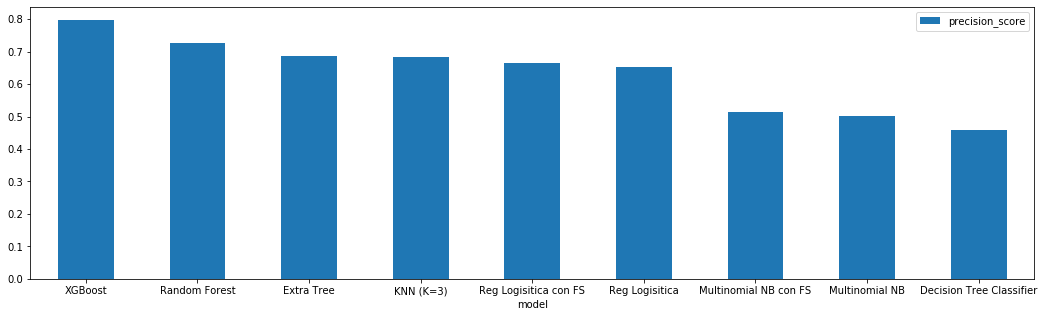

In [150]:
#graficamos los resultados
ax = df_precision.plot.bar(x='model', y='precision_score', rot=0, figsize=(18,5))

##### Recall

In [151]:
recall_metrics = []

#regresion logistica
recall_metrics.append({"recall_score": classification_report(y_test_simplified_smoted,reg_log_predicciones, output_dict=True)['2']['recall'], "model": "Reg Logisitica"})
#Multinomial NB
recall_metrics.append({"recall_score": classification_report(y_test_simplified_smoted,bnb_predicciones, output_dict=True)['2']['recall'], "model": "Multinomial NB"})
#KNN
recall_metrics.append({"recall_score": classification_report(y_test_simplified_smoted,knn_y_pred, output_dict=True)['2']['recall'], "model": "KNN (K="+ str(knn_grid.best_params_['clasificador__n_neighbors']) +")"})
#Decision Tree Classifier
recall_metrics.append({"recall_score": classification_report(y_test_simplified_smoted,classifier_tree_y_pred, output_dict=True)['2']['recall'], "model": "Decision Tree Classifier"})
#Random Forest
recall_metrics.append({"recall_score": classification_report(y_test_simplified_smoted,random_forest_y_pred, output_dict=True)['2']['recall'], "model": "Random Forest"})
#Extra Trees
recall_metrics.append({"recall_score": classification_report(y_test_simplified_smoted,extra_tree_y_pred, output_dict=True)['2']['recall'], "model": "Extra Tree"})
#XGBoost
recall_metrics.append({"recall_score": classification_report(y_test_simplified_smoted,xgb_y_pred, output_dict=True)['2']['recall'], "model": "XGBoost"})
#Regresion Logistica con FS
recall_metrics.append({"recall_score": classification_report(y_test_simplified_smoted,FS_reg_log_predicciones, output_dict=True)['2']['recall'], "model": "Reg Logisitica con FS"})
#Multinomial NB con FS
recall_metrics.append({"recall_score": classification_report(y_test_simplified_smoted,FS_bnb_predicciones, output_dict=True)['2']['recall'], "model": "Multinomial NB con FS"})


#lo pasamos a un dataframe
df_recall = pd.DataFrame(recall_metrics).sort_values(by='recall_score', ascending=False)

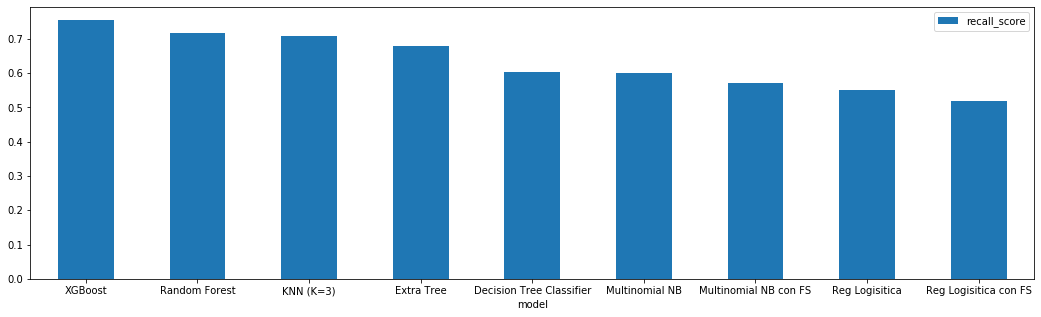

In [152]:
#graficamos los resultados
ax = df_recall.plot.bar(x='model', y='recall_score', rot=0, figsize=(18,5))

# Selección del modelo <a id="seleccion_modelo"></a>

<a href="#titulo">Volver al índice</a>

Analizando las performances de los distintos modelos, y los resultados de las métricas que incumben a nuestro problema (precision y recall), seleccionamos al modelo XGBoost

In [153]:
xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=19,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=70, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Prediciendo en el set de test 2020 <a id="test_analysis"></a>

<a href="#titulo">Volver al índice</a>

##### Levantamos el csv de test

In [154]:
pathArchivoDataSetTest = 'tracks_clean_test.csv' 
df_test = pd.read_csv(pathArchivoDataSetTest)

In [155]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 82 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   popularity          117 non-null    int64  
 1   name                117 non-null    object 
 2   album               117 non-null    object 
 3   duration_ms         117 non-null    int64  
 4   explicit            117 non-null    int64  
 5   danceability        117 non-null    float64
 6   energy              117 non-null    float64
 7   loudness            117 non-null    float64
 8   mode                117 non-null    int64  
 9   speechiness         117 non-null    float64
 10  acousticness        117 non-null    float64
 11  instrumentalness    117 non-null    float64
 12  liveness            117 non-null    float64
 13  valence             117 non-null    float64
 14  tempo               117 non-null    float64
 15  artista_generos     117 non-null    object 
 16  artista_

##### Verificamos que solo son temas del año 2020

In [156]:
df_year = df_test['release_date'].apply(lambda f: f[0:4])

In [157]:
#solo tiene datos del año actual
df_year.unique()

array(['2020'], dtype=object)

##### Aplicamos los mismos cambios en la variables que en el entrenamiento

##### Eliminamos repetidos por nombre de tema y nombre de artista, nos quedamos con el último

In [158]:
df_test = df_test.drop_duplicates(subset=['name','artista_name'],keep='last')

##### Eliminamos la fecha de lanzamiento del tema

In [159]:
df_test = df_test.drop(labels=['release_date'], axis=1)

#### Generación de dummies para el dato 'escala'

In [160]:
df_test = pd.get_dummies(df_test, drop_first=True, columns=['escala'])

##### Transformamos la variable duration_ms en duration, que es en minutos

In [161]:
df_test['duration'] = df_test['duration_ms'] / 1000 / 60

In [162]:
#quitamos la duracion en ms
df_test = df_test.drop(labels=['duration_ms'], axis=1)

##### Usamos nuestro mejor modelo, XGBoost

In [163]:
xgb

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           random_state=42, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None

##### Tomamos las features input para la predicción

In [164]:
df_prediccion = df_test[training_cols]

##### Aplicamos el escaler

In [165]:
scaler = StandardScaler()
x_resultados_test = scaler.fit_transform(df_prediccion)

In [166]:
y_resultados_pred = xgb.predict(x_resultados_test)

In [167]:
zipped = zip( df_prediccion.index, y_resultados_pred)
listado = list(zipped)

In [168]:
print("Clases posibles: " + str(target_classes_labels))

Clases posibles: {0: 'mala', 1: 'buena', 2: 'muy_buena'}


In [169]:
best_tracks_ids = []

for x in listado:
    if(x[1] == 2):
        best_tracks_ids.append(x[0])


In [170]:
df_test[df_test.index.isin(best_tracks_ids)][['name', 'artista_name', 'popularity']]

,name,artista_name,popularity
0,La Jeepeta - Remix,Nio Garcia,90
2,Elegí (feat. Dímelo Flow),Rauw Alejandro,89
11,Blinding Lights,The Weeknd,99
16,Recuerdo,TINI,73
18,La Cama - Remix,Lunay,82
20,La Pared 360,Lenny Tavárez,78
27,Rojo,J Balvin,84
32,Relación,Sech,81
33,BYE ME FUI,Bad Bunny,85
41,Moon,Maria Becerra,67


Los índices de popularidad de los tracks corresponden a la fecha en que fue creado el CSV. Aquellos tracks con popularidad alta, y que fueron elegidos, sirven como confirmación de que las otras features lo identificaron como un éxito (ej. el track "La Jeepeta - Remix" de Nio Garcia).
Los que tenían baja popularidad al momento de generar el CSV, pero fueron seleccionados con la clase 2 (muy_buena), de acuerdo al modelo, deberían tener un aumento en el índice de popularity para condecirse con las predicciones del modelo.